# Custom Pipeline - Prompt To Prompt Cross Attention control with Custom Model + Lora

Attempt

In [1]:
import torch 
import diffusers

print("Torch version:",torch.__version__)
print("Diffusers version:",diffusers.__version__)
print("Cuda available:",torch.cuda.is_available())
print("MPS available:",torch.backends.mps.is_available())
print("MPS built:",torch.backends.mps.is_built())

Torch version: 2.0.0
Diffusers version: 0.15.1
Cuda available: False
MPS available: True
MPS built: True


In [2]:
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import PIL

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype = torch.float32,
    safety_checker = None
)
pipe.to("mps")
pipe.enable_attention_slicing()

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

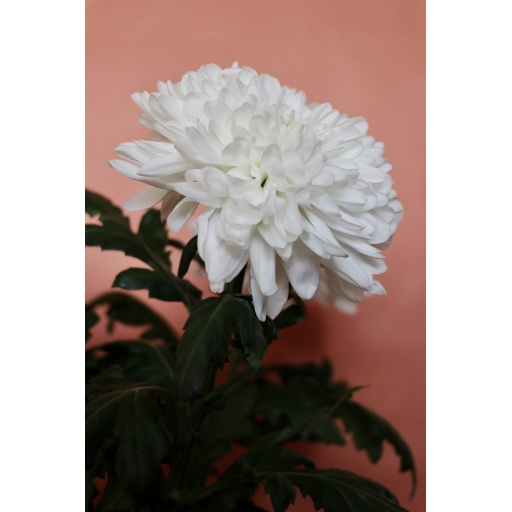

In [3]:
image = PIL.Image.open("images/000000887.jpg")
#image = image.resize((512,512))
image

  0%|          | 0/20 [00:00<?, ?it/s]

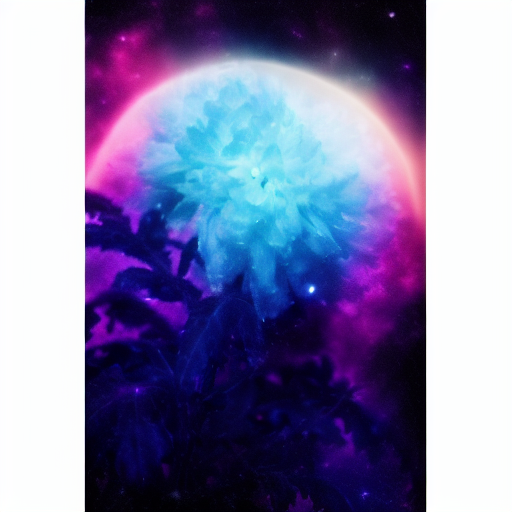

In [4]:
import math
import random 


prompt = "Space"
seed = random.randint(0, 2**32-1)
generator = torch.manual_seed(seed)

resImg = pipe(prompt, 
     image=image,
     num_inference_steps=20, 
     image_guidance_scale=1.5, 
     guidance_scale=7).images[0]

resImg

Let's try and attach a LoRA model to the pipeline.

In [5]:
# create ln -s to the lora folder 
from huggingface_hub import model_info
pipe.components

{'vae': AutoencoderKL(
   (encoder): Encoder(
     (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (down_blocks): ModuleList(
       (0): DownEncoderBlock2D(
         (resnets): ModuleList(
           (0-1): 2 x ResnetBlock2D(
             (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
             (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
             (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
             (dropout): Dropout(p=0.0, inplace=False)
             (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
             (nonlinearity): SiLU()
           )
         )
         (downsamplers): ModuleList(
           (0): Downsample2D(
             (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
           )
         )
       )
       (1): DownEncoderBlock2D(
         (resnets): ModuleList(
           (0): ResnetBlock2D(
             (norm1): GroupNorm(32, 128, eps=1e

In [7]:
#lora_path = "../models/SD-LORA-Weights/add_detail.safetensors"
#lora_path = "OedoSoldier/detail-tweaker-lora"
lora_path = "pcuenq/pokemon-lora"
pipe.unet.load_attn_procs(lora_path)
pipe.to("mps")

StableDiffusionInstructPix2PixPipeline {
  "_class_name": "StableDiffusionInstructPix2PixPipeline",
  "_diffusers_version": "0.15.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/20 [00:00<?, ?it/s]

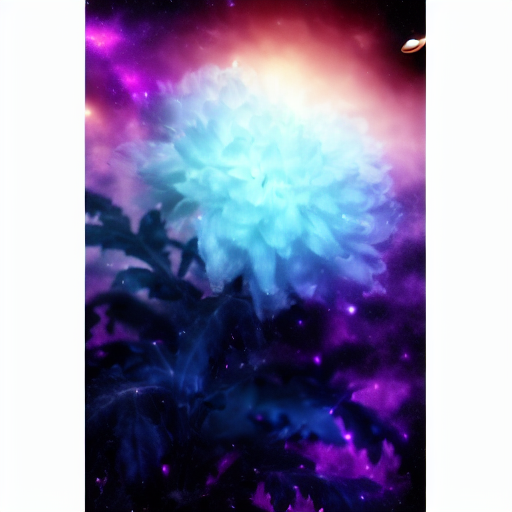

In [8]:
resImgLora = pipe(prompt, 
     image=image,
     num_inference_steps=20, 
     image_guidance_scale=1.5, 
     guidance_scale=7).images[0]

resImgLora

  0%|          | 0/20 [00:00<?, ?it/s]

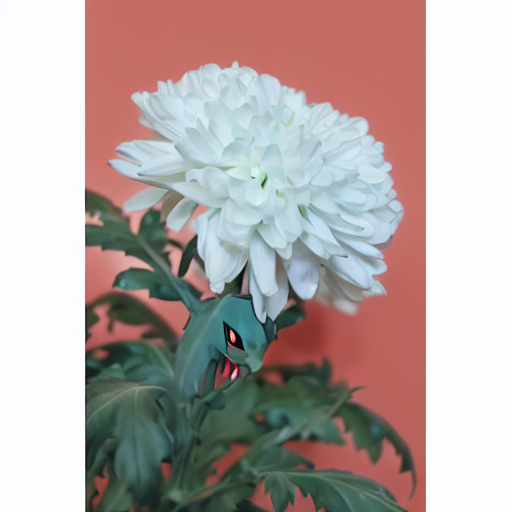

In [9]:
prompt = "Pokemon"
seed = 123456
generator = torch.manual_seed(seed)
resImg = pipe(prompt, 
     image=image,
     num_inference_steps=20, 
     image_guidance_scale=1.5, 
     guidance_scale=7,
     generator=generator).images[0]


resImg

  0%|          | 0/20 [00:00<?, ?it/s]

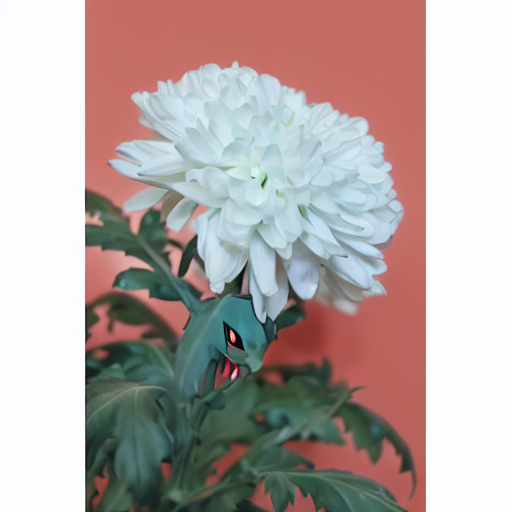

In [10]:
prompt = "Pokemon"
seed = 123456
generator = torch.manual_seed(seed)
resImg = pipe(prompt, 
     image=image,
     num_inference_steps=20, 
     image_guidance_scale=1.5, 
     guidance_scale=7,
     generator=generator).images[0]


resImg

  0%|          | 0/20 [00:00<?, ?it/s]

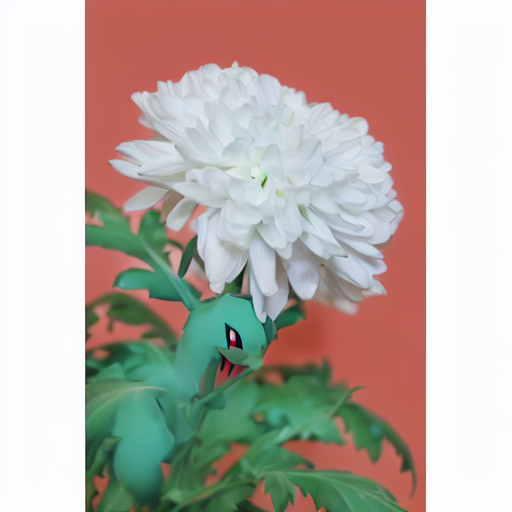

In [12]:
#pipe.unet.load_attn_procs(model_id) # reset to original and let's see difference
#pipe.to("mps")
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype = torch.float32,
    safety_checker = None
)
pipe.to("mps")
pipe.enable_attention_slicing()
prompt = "Pokemon"
seed = 123456
generator = torch.manual_seed(seed)
resImg = pipe(prompt, 
     image=image,
     num_inference_steps=20, 
     image_guidance_scale=1.5, 
     guidance_scale=7,
     generator=generator).images[0]


resImg

GREAT!!!!!! WE JUST USED A LORA 

  0%|          | 0/20 [00:00<?, ?it/s]

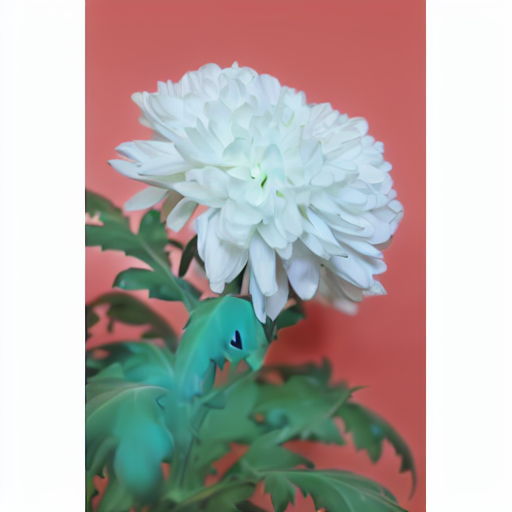

In [14]:
# let's make some actual real comparisons
prompt = "Turn the background into a big pokemon"
seed = 1234567
generator = torch.manual_seed(seed)
resImg = pipe(prompt, 
     image=image,
     num_inference_steps=20, 
     image_guidance_scale=1.5, 
     guidance_scale=7,
     generator=generator).images[0]


resImg

  0%|          | 0/20 [00:00<?, ?it/s]

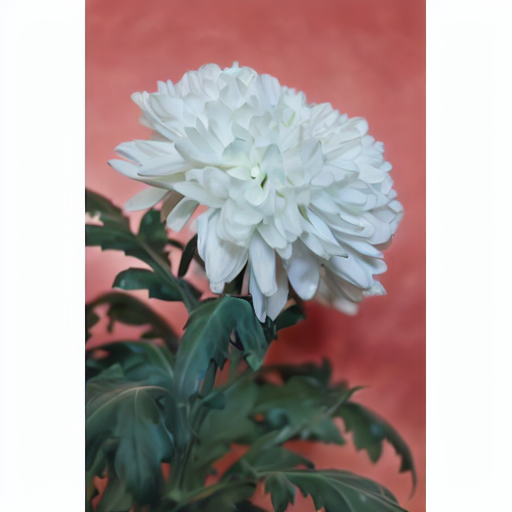

In [17]:
pipeLora = pipe
pipeLora.unet.load_attn_procs(lora_path)
pipeLora.to("mps")
resImgLora = pipeLora(prompt, 
     image=image,
     num_inference_steps=20, 
     image_guidance_scale=1.5, 
     guidance_scale=7,
     generator=generator).images[0]


resImgLora

In [19]:
# convert safetensor to bin 
from format_convert import safetensors_to_bin
lora_path = "../models/SD-LORA-Weights/add_detail.safetensors"
bin_path = "../models/SD-LORA-Weights/add_detail.bin"
safetensors_to_bin(lora_path, bin_path=bin_path)

In [24]:
from safetensors.torch import load_file
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# load diffusers model
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionPipeline.from_pretrained(model_id,torch_dtype=torch.float32)
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline.to("mps")

# load lora weight
model_path = "../models/SD-LORA-Weights/add_detail.safetensors"
state_dict = load_file(model_path, device="mps")


pipeline = pipe

LORA_PREFIX_UNET = 'lora_unet'
LORA_PREFIX_TEXT_ENCODER = 'lora_te'

alpha = 0.75

visited = []

# directly update weight in diffusers model
for key in state_dict:
    
    # it is suggested to print out the key, it usually will be something like below
    # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"
    
    # as we have set the alpha beforehand, so just skip
    if '.alpha' in key or key in visited:
        continue
        
    if 'text' in key:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_TEXT_ENCODER+'_')[-1].split('_')
        curr_layer = pipeline.text_encoder
    else:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_UNET+'_')[-1].split('_')
        curr_layer = pipeline.unet

    # find the target layer
    temp_name = layer_infos.pop(0)
    while len(layer_infos) > -1:
        try:
            curr_layer = curr_layer.__getattr__(temp_name)
            if len(layer_infos) > 0:
                temp_name = layer_infos.pop(0)
            elif len(layer_infos) == 0:
                break
        except Exception:
            if len(temp_name) > 0:
                temp_name += '_'+layer_infos.pop(0)
            else:
                temp_name = layer_infos.pop(0)
    
    # org_forward(x) + lora_up(lora_down(x)) * multiplier
    pair_keys = []
    if 'lora_down' in key:
        pair_keys.append(key.replace('lora_down', 'lora_up'))
        pair_keys.append(key)
    else:
        pair_keys.append(key)
        pair_keys.append(key.replace('lora_up', 'lora_down'))
    
    # update weight
    if len(state_dict[pair_keys[0]].shape) == 4:
        weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
        weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
    else:
        weight_up = state_dict[pair_keys[0]].to(torch.float32)
        weight_down = state_dict[pair_keys[1]].to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)
        
     # update visited list
    for item in pair_keys:
        visited.append(item)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

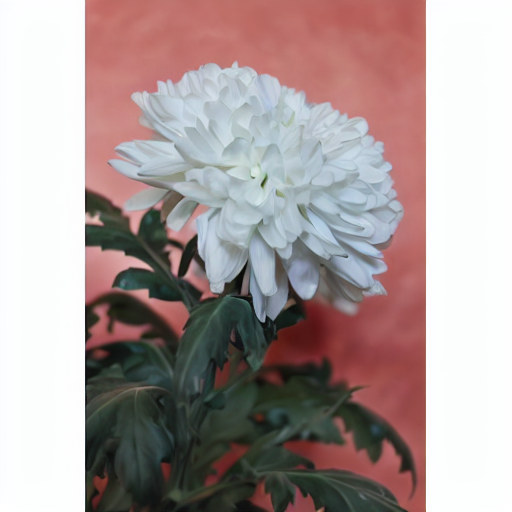

In [25]:
# pipeDetail = pipe
# pipeDetail.unet.load_attn_procs(bin_path)
# pipeDetail.to("mps")
resImgDetail = pipeline(prompt,
        image=image,
        num_inference_steps=20,
        image_guidance_scale=1.5,
        guidance_scale=7,
        generator=generator).images[0]

resImgDetail

In [26]:
from safetensors.torch import load_file
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionInstructPix2PixPipeline

# load diffusers model
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id,torch_dtype=torch.float32, safety_checker=None)
#pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline.to("mps")

# load lora weight
model_path = "../models/SD-LORA-Weights/milkyW.safetensors"
state_dict = load_file(model_path, device="mps")

LORA_PREFIX_UNET = 'lora_unet'
LORA_PREFIX_TEXT_ENCODER = 'lora_te'

alpha = 1

visited = []

# directly update weight in diffusers model
for key in state_dict:
    
    # it is suggested to print out the key, it usually will be something like below
    # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"
    
    # as we have set the alpha beforehand, so just skip
    if '.alpha' in key or key in visited:
        continue
        
    if 'text' in key:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_TEXT_ENCODER+'_')[-1].split('_')
        curr_layer = pipeline.text_encoder
    else:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_UNET+'_')[-1].split('_')
        curr_layer = pipeline.unet

    # find the target layer
    temp_name = layer_infos.pop(0)
    while len(layer_infos) > -1:
        try:
            curr_layer = curr_layer.__getattr__(temp_name)
            if len(layer_infos) > 0:
                temp_name = layer_infos.pop(0)
            elif len(layer_infos) == 0:
                break
        except Exception:
            if len(temp_name) > 0:
                temp_name += '_'+layer_infos.pop(0)
            else:
                temp_name = layer_infos.pop(0)
    
    # org_forward(x) + lora_up(lora_down(x)) * multiplier
    pair_keys = []
    if 'lora_down' in key:
        pair_keys.append(key.replace('lora_down', 'lora_up'))
        pair_keys.append(key)
    else:
        pair_keys.append(key)
        pair_keys.append(key.replace('lora_up', 'lora_down'))
    
    # update weight
    if len(state_dict[pair_keys[0]].shape) == 4:
        weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
        weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
    else:
        weight_up = state_dict[pair_keys[0]].to(torch.float32)
        weight_down = state_dict[pair_keys[1]].to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)
        
     # update visited list
    for item in pair_keys:
        visited.append(item)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_instruct_pix2pix.StableDiffusionInstructPix2PixPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Amazing. The difference is not crazy but it's enough to notice. This means we can attempt to load the milkyW model.


In [27]:
prompt = "Space"
seed = 1234567
generator = torch.manual_seed(seed)
resMilky = pipeline(prompt,
        image=image,
        num_inference_steps=20,
        image_guidance_scale=1.5,
        guidance_scale=7,
        generator=generator).images[0]

resMilky

ValueError: Incorrect configuration settings! The config of `pipeline.unet`: FrozenDict([('sample_size', 64), ('in_channels', 4), ('out_channels', 4), ('center_input_sample', False), ('flip_sin_to_cos', True), ('freq_shift', 0), ('down_block_types', ['CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D']), ('mid_block_type', 'UNetMidBlock2DCrossAttn'), ('up_block_types', ['UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D']), ('only_cross_attention', False), ('block_out_channels', [320, 640, 1280, 1280]), ('layers_per_block', 2), ('downsample_padding', 1), ('mid_block_scale_factor', 1), ('act_fn', 'silu'), ('norm_num_groups', 32), ('norm_eps', 1e-05), ('cross_attention_dim', 768), ('encoder_hid_dim', None), ('attention_head_dim', 8), ('dual_cross_attention', False), ('use_linear_projection', False), ('class_embed_type', None), ('num_class_embeds', None), ('upcast_attention', False), ('resnet_time_scale_shift', 'default'), ('resnet_skip_time_act', False), ('resnet_out_scale_factor', 1.0), ('time_embedding_type', 'positional'), ('time_embedding_act_fn', None), ('timestep_post_act', None), ('time_cond_proj_dim', None), ('conv_in_kernel', 3), ('conv_out_kernel', 3), ('projection_class_embeddings_input_dim', None), ('class_embeddings_concat', False), ('mid_block_only_cross_attention', None), ('cross_attention_norm', None), ('_class_name', 'UNet2DConditionModel'), ('_diffusers_version', '0.6.0'), ('_name_or_path', '/Users/jacopoferro/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/aa9ba505e1973ae5cd05f5aedd345178f52f8e6a/unet')]) expects 4 but received `num_channels_latents`: 4 + `num_channels_image`: 4  = 8. Please verify the config of `pipeline.unet` or your `image` input.

In [30]:
# interesting the error code, indeed instruct Pix 2 Pix has 4 extra channels

from safetensors.torch import load_file
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionInstructPix2PixPipeline

# load diffusers model
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id,torch_dtype=torch.float32, safety_checker=None)
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline.to("mps")

# load lora weight
model_path = "../models/SD-LORA-Weights/add_detail.safetensors"
state_dict = load_file(model_path, device="mps")

LORA_PREFIX_UNET = 'lora_unet'
LORA_PREFIX_TEXT_ENCODER = 'lora_te'

alpha = 1

visited = []

# directly update weight in diffusers model
for key in state_dict:
    
    # it is suggested to print out the key, it usually will be something like below
    # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"
    
    # as we have set the alpha beforehand, so just skip
    if '.alpha' in key or key in visited:
        continue
        
    if 'text' in key:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_TEXT_ENCODER+'_')[-1].split('_')
        curr_layer = pipeline.text_encoder
    else:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_UNET+'_')[-1].split('_')
        curr_layer = pipeline.unet

    # find the target layer
    temp_name = layer_infos.pop(0)
    while len(layer_infos) > -1:
        try:
            curr_layer = curr_layer.__getattr__(temp_name)
            if len(layer_infos) > 0:
                temp_name = layer_infos.pop(0)
            elif len(layer_infos) == 0:
                break
        except Exception:
            if len(temp_name) > 0:
                temp_name += '_'+layer_infos.pop(0)
            else:
                temp_name = layer_infos.pop(0)
    
    # org_forward(x) + lora_up(lora_down(x)) * multiplier
    pair_keys = []
    if 'lora_down' in key:
        pair_keys.append(key.replace('lora_down', 'lora_up'))
        pair_keys.append(key)
    else:
        pair_keys.append(key)
        pair_keys.append(key.replace('lora_up', 'lora_down'))
    
    # update weight
    if len(state_dict[pair_keys[0]].shape) == 4:
        weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
        weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
    else:
        weight_up = state_dict[pair_keys[0]].to(torch.float32)
        weight_down = state_dict[pair_keys[1]].to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)
        
     # update visited list
    for item in pair_keys:
        visited.append(item)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_instruct_pix2pix.StableDiffusionInstructPix2PixPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [31]:
prompt = "Space"
seed = 1234567
generator = torch.manual_seed(seed)
resMilky = pipeline(prompt,
        image=image,
        num_inference_steps=20,
        image_guidance_scale=1.5,
        guidance_scale=7,
        generator=generator).images[0]

resMilky

ValueError: Incorrect configuration settings! The config of `pipeline.unet`: FrozenDict([('sample_size', 64), ('in_channels', 4), ('out_channels', 4), ('center_input_sample', False), ('flip_sin_to_cos', True), ('freq_shift', 0), ('down_block_types', ['CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D']), ('mid_block_type', 'UNetMidBlock2DCrossAttn'), ('up_block_types', ['UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D']), ('only_cross_attention', False), ('block_out_channels', [320, 640, 1280, 1280]), ('layers_per_block', 2), ('downsample_padding', 1), ('mid_block_scale_factor', 1), ('act_fn', 'silu'), ('norm_num_groups', 32), ('norm_eps', 1e-05), ('cross_attention_dim', 768), ('encoder_hid_dim', None), ('attention_head_dim', 8), ('dual_cross_attention', False), ('use_linear_projection', False), ('class_embed_type', None), ('num_class_embeds', None), ('upcast_attention', False), ('resnet_time_scale_shift', 'default'), ('resnet_skip_time_act', False), ('resnet_out_scale_factor', 1.0), ('time_embedding_type', 'positional'), ('time_embedding_act_fn', None), ('timestep_post_act', None), ('time_cond_proj_dim', None), ('conv_in_kernel', 3), ('conv_out_kernel', 3), ('projection_class_embeddings_input_dim', None), ('class_embeddings_concat', False), ('mid_block_only_cross_attention', None), ('cross_attention_norm', None), ('_class_name', 'UNet2DConditionModel'), ('_diffusers_version', '0.6.0'), ('_name_or_path', '/Users/jacopoferro/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/aa9ba505e1973ae5cd05f5aedd345178f52f8e6a/unet')]) expects 4 but received `num_channels_latents`: 4 + `num_channels_image`: 4  = 8. Please verify the config of `pipeline.unet` or your `image` input.

Let's take a step back and use a text to image, afterall both the LoRA and the prompt-to-prompt are meant for that

In [32]:
import torch
from diffusers import StableDiffusionPipeline

In [33]:
sd = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32)
sd.to("mps")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.15.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/20 [00:00<?, ?it/s]

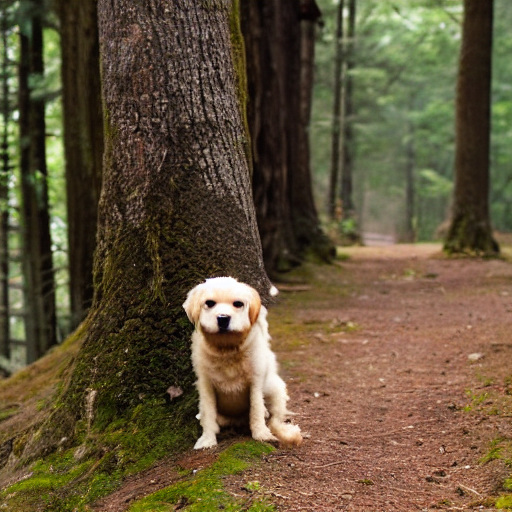

In [34]:
seed = 1234567
generator = torch.manual_seed(seed)
resImg = sd("A dog in the forest",
        num_inference_steps=20,
        guidance_scale=7,
        generator=generator).images[0]

resImg

In [46]:
# let's add detail lora
# from diffusers.loaders import LoraLoaderMixin, LoRAAttnProcessor
from safetensors.torch import load_file
lora_path = "../models/SD-LORA-Weights/milkyW.safetensors"
# sd_lora = load_lora_weights(sd) 
lora_weights = load_file(lora_path, device="mps")
sd.load_lora_weights(lora_weights) 

KeyError: 'to_k_lora.down.weight'

In [52]:
# these bugs are literally issues of 9h ago in the official repos and github of diffusers and hugging face
# essentially the problem is: LoRa in safetensors format from civitai or others which cannot be loaded nicely into diffusers
# here's a workaround similar to what we were doing before:
# https://github.com/huggingface/diffusers/issues/3064#issuecomment-1512429695

from collections import defaultdict
def load_lora_weights(pipeline, checkpoint_path, multiplier, device, dtype):
    LORA_PREFIX_UNET = "lora_unet"
    LORA_PREFIX_TEXT_ENCODER = "lora_te"
    # load LoRA weight from .safetensors
    state_dict = load_file(checkpoint_path, device=device)

    updates = defaultdict(dict)
    for key, value in state_dict.items():
        # it is suggested to print out the key, it usually will be something like below
        # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"

        layer, elem = key.split('.', 1)
        updates[layer][elem] = value

    # directly update weight in diffusers model
    for layer, elems in updates.items():

        if "text" in layer:
            layer_infos = layer.split(LORA_PREFIX_TEXT_ENCODER + "_")[-1].split("_")
            curr_layer = pipeline.text_encoder
        else:
            layer_infos = layer.split(LORA_PREFIX_UNET + "_")[-1].split("_")
            curr_layer = pipeline.unet

        # find the target layer
        temp_name = layer_infos.pop(0)
        while len(layer_infos) > -1:
            try:
                curr_layer = curr_layer.__getattr__(temp_name)
                if len(layer_infos) > 0:
                    temp_name = layer_infos.pop(0)
                elif len(layer_infos) == 0:
                    break
            except Exception:
                if len(temp_name) > 0:
                    temp_name += "_" + layer_infos.pop(0)
                else:
                    temp_name = layer_infos.pop(0)

        # get elements for this layer
        weight_up = elems['lora_up.weight'].to(dtype)
        weight_down = elems['lora_down.weight'].to(dtype)
        alpha = elems['alpha']
        if alpha:
            alpha = alpha.item() / weight_up.shape[1]
        else:
            alpha = 1.0

        # update weight
        if len(weight_up.shape) == 4:
            curr_layer.weight.data += multiplier * alpha * torch.mm(weight_up.squeeze(3).squeeze(2), weight_down.squeeze(3).squeeze(2)).unsqueeze(2).unsqueeze(3)
        else:
            curr_layer.weight.data += multiplier * alpha * torch.mm(weight_up, weight_down)

    return pipeline

In [49]:
sd.load_lora_weights(lora_weights, multiplier=1.0, device="mps", dtype=torch.float32)

KeyError: 'to_k_lora.down.weight'

In [53]:

sd_lora = load_lora_weights(sd, lora_path, multiplier=1.0, device="mps", dtype=torch.float32)
sd_lora.to("mps")


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.15.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/20 [00:00<?, ?it/s]

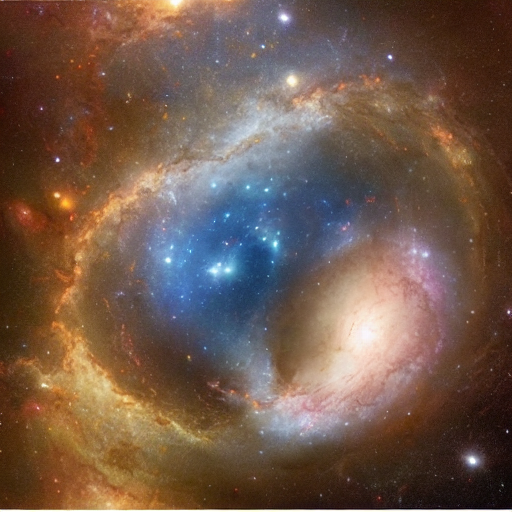

In [54]:
imgLora = sd_lora(prompt,
        num_inference_steps=20,
        guidance_scale=7,
        generator=generator).images[0]
imgLora

YES! IT WORKS! IMAGE TO IMAGE BABY